# Plot predicted trajectories using saved models

In [1]:
import os
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import torch

from imitation_cl.train.utils import check_cuda, get_sequence
from imitation_cl.model.hypernetwork import HyperNetwork, TargetNetwork, ChunkedHyperNetwork, str_to_ints, str_to_act
from imitation_cl.model.node import NODE
from imitation_cl.plot.trajectories import plot_ode_simple
from imitation_cl.logging.utils import read_dict, Dictobject
from imitation_cl.data.lasa import LASA
from imitation_cl.data.helloworld import HelloWorld
#from tr_hn_node import eval_task as hn_eval_task
#from tr_chn_node import eval_task as chn_eval_task

In [2]:
def predict_traj_task(args, task_id, hnet, tnet, node, device, denorm=False):

    hnet.eval()
    tnet.eval()

    tnet = tnet.to(device)
    hnet = hnet.to(device)
    node = node.to(device)

    filenames = get_sequence(args.seq_file)

    data = None
    if args.data_class == 'LASA':
        data = LASA(data_dir=args.data_dir, filename=filenames[task_id])
    elif args.data_class == 'HelloWorld':
        data = HelloWorld(data_dir=args.data_dir, filename=filenames[task_id])
    else:
        raise NotImplementedError(f'Unknown dataset class {args.data_class}')

    # Generate parameters of the target network for the current task
    weights = hnet.forward(task_id)

    # Set the weights of the target network
    tnet.set_weights(weights)

    # Set the target network in the NODE
    node.set_target_network(tnet)
    node = node.float()
    node.eval()

    # The time steps
    t = torch.from_numpy(data.t[0]).float().to(device)

    # The starting position 
    # (n,d-dimensional, where n is the num of demos and 
    # d is the dimension of each point)
    y_start = torch.from_numpy(data.pos[:,0]).float().to(device)

    # The entire demonstration trajectory
    y_all = data.pos

    # Predicted trajectory
    y_hat = node(t, y_start) # forward simulation

    if denorm:   
        y_hat = data.unnormalize(y_hat.detach().cpu().numpy())
    else:
        y_hat = y_hat.detach().cpu().numpy()

    return y_all, t, y_hat

In [3]:
def predict_traj(model_dir, num_tasks, net_type='hn', demo_num=0, denorm=False):
    """Plot the predicted and ground truth trajectories for different tasks.
    Trained models saved on disk are used to produce the predictions.

    Args:
        model_dir (str): Directory where saved models are provided
        num_tasks (int): Total number of tasks for the corresponding dataset
        device (torch.device): 'cpu' or 'cuda'
        net_type (str, optional): Type of hypernetwork ('hn'|'chn'). Defaults to 'hn'.
    """

    assert net_type in ['hn','chn'], f'Unknown hypernetwork type {net_type}'

    cuda_available, device = check_cuda()

    commandline_args_path = os.path.join(model_dir, f'{net_type}_commandline_args.json')

    # ID of the last task (task_ids range from 0 to num_tasks-1)
    train_task_id = num_tasks - 1

    # Path of the saved model (model trained on the last task)
    model_path = os.path.join(model_dir, f'{net_type}_{train_task_id}.pth')

    # Use the same command line arguments that were used during training
    args = Dictobject(read_dict(commandline_args_path))

    # Shapes of the target network parameters
    target_shapes = TargetNetwork.weight_shapes(n_in=args.tnet_dim+args.explicit_time, 
                                                n_out=args.tnet_dim, 
                                                hidden_layers=str_to_ints(args.tnet_arch), 
                                                use_bias=True)

    # Create the hypernetwork
    hnet = None
    if net_type == 'hn':
        hnet = HyperNetwork(layers=str_to_ints(args.hnet_arch), 
                            te_dim=args.task_emb_dim, 
                            target_shapes=target_shapes,
                            device=device).to(device)
    elif net_type == 'chn':
        hnet = ChunkedHyperNetwork(final_target_shapes=target_shapes,
                                   layers=str_to_ints(args.hnet_arch),
                                   chunk_dim=args.chunk_dim,
                                   te_dim=args.task_emb_dim,
                                   ce_dim=args.chunk_emb_dim,
                                   device=device).to(device)    
            
    # Create a target network without parameters
    # Parameters are supplied during the forward pass of the hypernetwork
    tnet = TargetNetwork(n_in=args.tnet_dim+args.explicit_time, 
                         n_out=args.tnet_dim, 
                         hidden_layers=str_to_ints(args.tnet_arch),
                         activation_fn=str_to_act(args.tnet_act), 
                         use_bias=True, 
                         no_weights=True,
                         init_weights=None, 
                         dropout_rate=-1, 
                         use_batch_norm=False, 
                         bn_track_stats=False,
                         distill_bn_stats=False, 
                         out_fn=None,
                         device=device).to(device)

    # The NODE uses the target network as the RHS of its
    # differential equation
    # Apart from this, the NODE has no other trainable parameters
    node = NODE(tnet, explicit_time=args.explicit_time).to(device)

    # Load the hyper network for the last task_id
    if cuda_available:
        hnet = torch.load(model_path)
    else:
        hnet = torch.load(model_path, map_location=torch.device('cpu'))
        hnet.device = torch.device('cpu')

    # Show paramater size of hypernetwork
    network_type = 'HyperNetwork' if net_type == 'hn' else 'ChunkedHyperNetwork'
    print(f'Network type: {network_type}')
    param_size = 0
    for n, p in hnet.named_parameters():
        param_size += np.prod(list(p.shape))
    print(f'Parameter size: {param_size:,}')
    print(f'Size of model on disk: {os.path.getsize(model_path)/(1024*1024):.2f} MB')

    # Create a figure for plotting the predicted trajectories
    figw, figh = args.figw, args.figh
    plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh)
    fig, axes = plt.subplots(figsize=(figw, figh), 
                                sharey=True, 
                                sharex=True,
                                ncols=num_tasks if num_tasks<=10 else (num_tasks//2), 
                                nrows=1 if num_tasks<=10 else 2,
                                subplot_kw={'aspect': 1})

    # Row column for plot with trajectories
    r, c = 0, 0

    demos = list()
    # Evaluate on all the past and current task_ids
    for eval_task_id in trange(train_task_id+1):
        # Figure is plotted only for the last task
        
        #eval_task = hn_eval_task if net_type == 'hn' else chn_eval_task
        y_all, t, y_hat = predict_traj_task(args, eval_task_id, hnet, tnet, node, device, denorm)

        # Plot the trajectories predicted by the loaded model

        # Read the task names to use in the plot
        task_names_map = read_dict(args.task_names_path)

        r = 1 if num_tasks<=10 else eval_task_id//(num_tasks//2)
        c = eval_task_id if num_tasks<=10 else eval_task_id%(num_tasks//2)
        ax = axes[c] if num_tasks<=10 else axes[r][c]
        name = list(task_names_map.values())[eval_task_id]
        ax.set_title(name, fontsize=args.plot_fs)
        demo_hat = y_hat[demo_num,:,:]
        ax.plot(demo_hat[:,0], demo_hat[:,1])
        
        # Remove axis labels and ticks
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
        #ax.xaxis.get_label().set_visible(False)
        #ax.yaxis.get_label().set_visible(False)

        # Helloworld demos are recorded from the robot's perspective
        # Reflect the trajectories for better readability on the screen
        #if 'helloworld' in model_dir:
        #    ax.invert_xaxis()
        #    ax.invert_yaxis()
        demos.append(y_hat)

    fig.subplots_adjust(hspace=-0.2, wspace=0.1)
    return demos

## LASA (with time input) - Hypernetwork

Network type: HyperNetwork
Parameter size: 4,319,658
Size of model on disk: 16.49 MB


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


<Figure size 432x288 with 0 Axes>

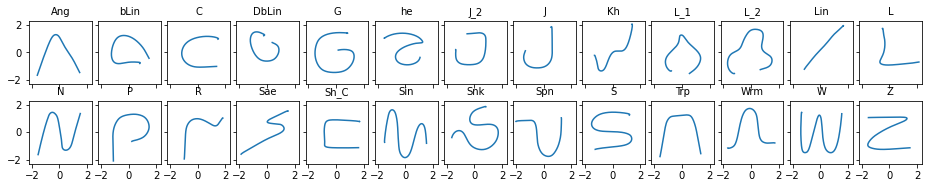

In [4]:
demos = predict_traj(model_dir='trained_models/lasa/explicit_time', num_tasks=26, net_type='hn', demo_num=1, denorm=False)

## Helloworld (with time input) - Hypernetwork

  0%|          | 0/7 [00:00<?, ?it/s]

Network type: HyperNetwork
Parameter size: 4,314,794
Size of model on disk: 16.47 MB


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


<Figure size 432x288 with 0 Axes>

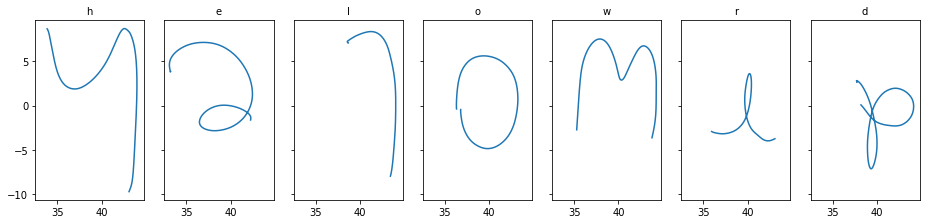

In [5]:
demos = predict_traj(model_dir='trained_models/helloworld/explicit_time', num_tasks=7, net_type='hn', demo_num=3, denorm=True)

In [6]:
import math
def rotate(arr, radians):
    """Only rotate a point around the origin (0, 0)."""
    x, y = arr[:,0], arr[:,1]
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)
    arr[:,0] = xx
    arr[:,1] = yy
    return arr

def scale(arr, scale_by=1.0):
    return arr*scale_by

def scale_y(arr, scale_by=1.0):
    arr[:,1] = arr[:,1]*scale_by
    return arr

def translate(arr, translate_by):
    arr[:,0] += translate_by[0]
    arr[:,1] += translate_by[1]
    return arr

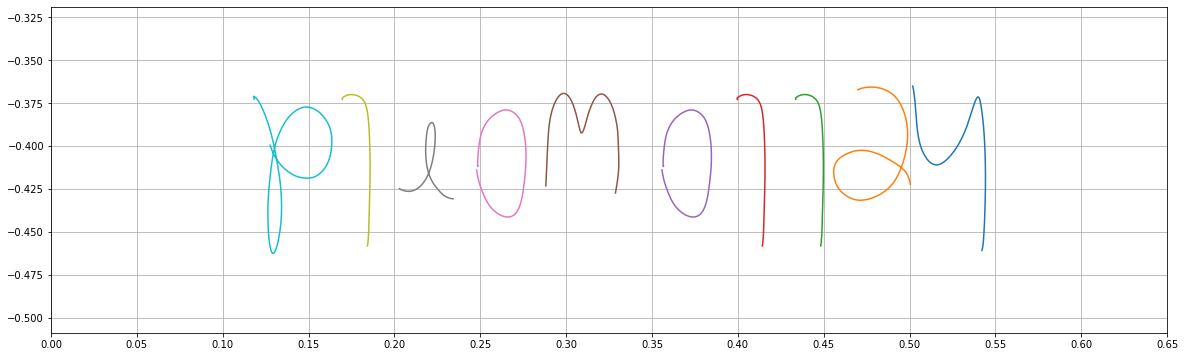

In [7]:
helloworld_list = list()
helloworld_list.append(demos[0]/100.0) #h
helloworld_list.append(demos[1]/100.0) #e
helloworld_list.append(demos[2]/100.0) #l
helloworld_list.append(demos[2]/100.0) #l
helloworld_list.append(demos[3]/100.0) #o
helloworld_list.append(demos[4]/100.0) #w
helloworld_list.append(demos[3]/100.0) #o
helloworld_list.append(demos[5]/100.0) #r
helloworld_list.append(demos[2]/100.0) #l
helloworld_list.append(demos[6]/100.0) #d

base_translate = np.array([-0.11,0])
first_translate = np.array([1.9,6.3])

fig,ax = plt.subplots(1,1, figsize=(20,6))

robot_list = list()

for i,d in enumerate(helloworld_list):

    letter = d[0] + i*base_translate + first_translate
    if i==9:
        letter = scale(letter, 0.7)
        letter -= 6.7*base_translate + 0.8*first_translate
        letter += np.array([0.0, 0.325])
    else:
        letter = scale(letter, 0.4)
        letter -= 4.2*base_translate + .45*first_translate
    if i==3:
        letter += np.array([0.01, 0.0])
    if i==4:
        letter += np.array([0.02, 0.0])
    letter = scale_y(letter, 1.3)
    ax.plot(letter[:,0],letter[:,1])
    robot_list.append(letter)
    ax.axis('equal')
    ax.set_xticks(np.arange(0.0,0.7,0.05))
    ax.grid(True)


In [8]:
robot_file = 'datasets/robot_hello_world/execute_helloworld.txt'


start_x = 0.586
start_y = -0.377

z_down = 0.098
z_up = 0.13

q0 = 0.998
q1 = -0.0503
q2 = -0.0056
q3 = -0.0048

with open(robot_file, 'w') as f:
    
    
    for r in robot_list:

        # Write a letter
        for j,pt in enumerate(r):
            x = pt[0]
            y = pt[1]
            if j==0:
                # Go on top of letter
                for k in range(50):
                    f.write(f'{x:0.10f} {y:0.10f} {z_up:0.10f} {q0:0.10f} {q1:0.10f} {q2:0.10f} {q3:0.10f}\n')
            # Go down and write letter
            f.write(f'{x:0.10f} {y:0.10f} {z_down:0.10f} {q0:0.10f} {q1:0.10f} {q2:0.10f} {q3:0.10f}\n')

        # Go up
        for k in range(50):
            f.write(f'{x:0.10f} {y:0.10f} {z_up:0.10f} {q0:0.10f} {q1:0.10f} {q2:0.10f} {q3:0.10f}\n')


In [9]:
!wc -l datasets/robot_hello_world/execute_helloworld_6.txt

10020 datasets/robot_hello_world/execute_helloworld_6.txt
